In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ripple_heterogeneity.utils import functions, loading,add_new_deep_sup
from ripple_heterogeneity.assembly import (
    assembly,
    assembly_individual_epochs,
    assembly_run,
    find_sig_assembly,
    assembly_reactivation
)
import nelpy as nel
import nelpy.plotting as npl
import os
import pickle
import glob
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
import random
from neo.rawio import neuroscoperawio
from tqdm import tqdm
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from xml.etree import ElementTree


def parse_xml_channel_groups(filename):
    filename = filename.replace(".xml", "").replace(".dat", "")

    tree = ElementTree.parse(filename + ".xml")
    root = tree.getroot()

    # find channels
    channel_group = []
    for grp_index, xml_chx in enumerate(
        root.find("anatomicalDescription").find("channelGroups").findall("group")
    ):
        for xml_rc in xml_chx:
            channel_group.append([int(xml_rc.text), grp_index])
    return np.array(channel_group)


In [22]:
def plot_deep_sup_assembly_example(st, reader, plotting_epoch, ca1_deep_idx, ca1_sup_idx, channel_indexes):
    fig, axs = plt.subplots(
        2,
        1,
        figsize=functions.set_size("thesis", fraction=.5, subplots=(2, 1)),
        edgecolor=None,
    )
    fig.subplots_adjust(hspace=0.1, wspace=0.2)
    axs = axs.ravel()

    group_colors = {
        "Deep": "#7b3294",
        "Superficial": "#008837",
        "middle":"#808080"
    }
    # rip = 9
    # rip = 1358
    # rip = 5325
    # rip = 88

    # window = .25
    # plotting_epoch = nel.EpochArray([np.array([ripples[rip].start - window / 2, ripples[rip].stop + window / 2]).T])
    # middle = np.median([ripples[rip].start,ripples[rip].stop])
    # plotting_epoch = nel.EpochArray([np.array([middle - window / 2, middle + window / 2]).T])

    seconds_idx = np.array([plotting_epoch.start,plotting_epoch.stop])
    # convert to index
    to_idx = (seconds_idx*reader.get_signal_sampling_rate()).astype(int)
    # get chunk of data
    raw_sigs = reader.get_analogsignal_chunk(i_start=to_idx[0],
                                            i_stop=to_idx[1],
                                            channel_indexes=channel_indexes)
                                            
    ts = np.linspace(plotting_epoch.start, plotting_epoch.stop, raw_sigs.shape[0])
    axs[0].plot(ts, raw_sigs[:, 0:2], color="k", linewidth=0.25)

    peak_order = st[plotting_epoch].iloc[:, ca1_sup_idx].get_event_firing_order()
    npl.rasterplot(
        st[plotting_epoch].iloc[:, ca1_sup_idx].reorder_units_by_ids(peak_order),
        lw=1,
        lh=3,
        ax=axs[1],
        color=group_colors["Superficial"],
        vertstack=True,
    )
    peak_order = st[plotting_epoch].iloc[:, ca1_deep_idx].get_event_firing_order()
    npl.rasterplot(
        st[plotting_epoch].iloc[:, ca1_deep_idx].reorder_units_by_ids(peak_order),
        lw=1,
        lh=3,
        ax=axs[1],
        color=group_colors["Deep"],
        vertstack=True,
    )

    # for i,color in enumerate(colors):
    #     axs[2].plot(
    #         assembly_act[plotting_epoch].abscissa_vals, assembly_act[plotting_epoch].data[i],color=color,
    #     )

    # x = np.linspace(plotting_epoch.start,plotting_epoch.stop,4)
    # axs[2].set_xticks(x)
    # axs[2].set_xticklabels(np.round(x-plotting_epoch.start,2))

    # axs[1].set_ylim(-2,cell_metrics.UID.unique().shape[0])
    # axs[1].set_ylim(-2,cell_metrics.UID.unique().shape[0])
    # axs[1].set_yticks(np.linspace(0,cell_metrics.UID.unique().shape[0],2))
    # axs[1].set_xticklabels(np.linspace(0,cell_metrics.UID.unique().shape[0],2))
    axs[1].set_ylabel('Unit ID')

    # axs[2].set_ylabel('Assembly \n strength')
    # axs[2].set_xlabel('time (sec)')

    for i in range(len(axs)):
        axs[i].spines["top"].set_visible(False)
        axs[i].spines["right"].set_visible(False)
        axs[i].xaxis.set_minor_locator(AutoMinorLocator())
        axs[i].set_xlim(plotting_epoch.start,plotting_epoch.stop)   

    axs[0].axes.xaxis.set_visible(False)
    axs[0].axes.yaxis.set_visible(False)
    axs[0].spines["top"].set_visible(False)
    axs[0].spines["bottom"].set_visible(False)
    axs[0].spines["right"].set_visible(False)
    axs[0].spines["left"].set_visible(False)  

    axs[1].spines["bottom"].set_visible(False)
    axs[1].axes.xaxis.set_visible(False)
    # axs[1].spines["left"].set_visible(False)  

    # axs[1].yaxis.set_minor_locator(AutoMinorLocator())
    # axs[2].yaxis.set_minor_locator(AutoMinorLocator())
    # axs[2].xaxis.set_minor_locator(AutoMinorLocator())



In [26]:
reader = neuroscoperawio.NeuroScopeRawIO(r"Z:/Data/HMC1/day10/day10")
reader.parse_header()
channel_group = parse_xml_channel_groups(reader.filename)
shank = 9
channel_indexes = channel_group[channel_group[:, 1] == shank, 0]
# channel_indexes = [293,314,32,416]
channel_indexes = [257]

In [6]:
basepath = r"Z:/Data/HMC1/day10"
st, cell_metrics = loading.load_spikes(basepath,putativeCellType="Pyr",brainRegion="CA1")

In [13]:
ca1_deep_idx = (
    cell_metrics.brainRegion.str.contains("CA1")
    & cell_metrics.deepSuperficial.str.contains("Deep")
).values
ca1_sup_idx = (
    cell_metrics.brainRegion.str.contains("CA1")
    & cell_metrics.deepSuperficial.str.contains("Superficial")
).values


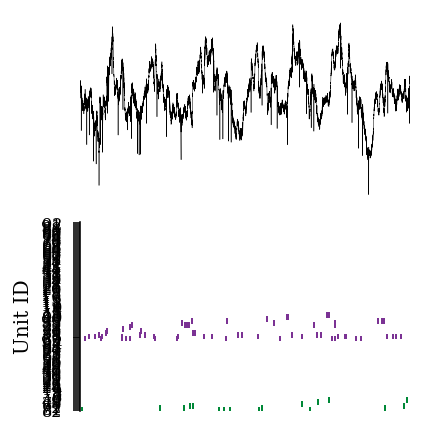

In [62]:
plotting_epoch = nel.EpochArray([np.array([11432,11432+1]).T])

plot_deep_sup_assembly_example(st, reader, plotting_epoch, ca1_deep_idx, ca1_sup_idx, channel_indexes)


In [35]:
lfp = loading.LoadLfp(basepath,257)

In [40]:
lfp.lfp[plotting_epoch]

<AnalogSignalArray at 0x2df3442f9a0: 1 signals> for a total of 1 seconds

In [73]:
from bycycle.features import compute_features
from bycycle.plts import plot_burst_detect_summary, plot_cyclepoints_array
# seconds_idx = np.array([plotting_epoch.start,plotting_epoch.stop])
# # convert to index
# to_idx = (seconds_idx*reader.get_signal_sampling_rate()).astype(int)
# # get chunk of data
# raw_sigs = reader.get_analogsignal_chunk(i_start=to_idx[0],
#                                         i_stop=to_idx[1],
#                                         channel_indexes=channel_indexes)
sigs = lfp.lfp[plotting_epoch.expand(2)].data[0]
f_theta = (4, 10)

threshold_kwargs = {'amp_fraction_threshold': .3,
                    'amp_consistency_threshold': .4,
                    'period_consistency_threshold': .5,
                    'monotonicity_threshold': .5,
                    'min_n_cycles': 3}

df_features = compute_features(sigs, lfp.lfp.fs, f_theta, threshold_kwargs=threshold_kwargs)

# df_features = compute_features(sigs, lfp.lfp.fs, f_theta)

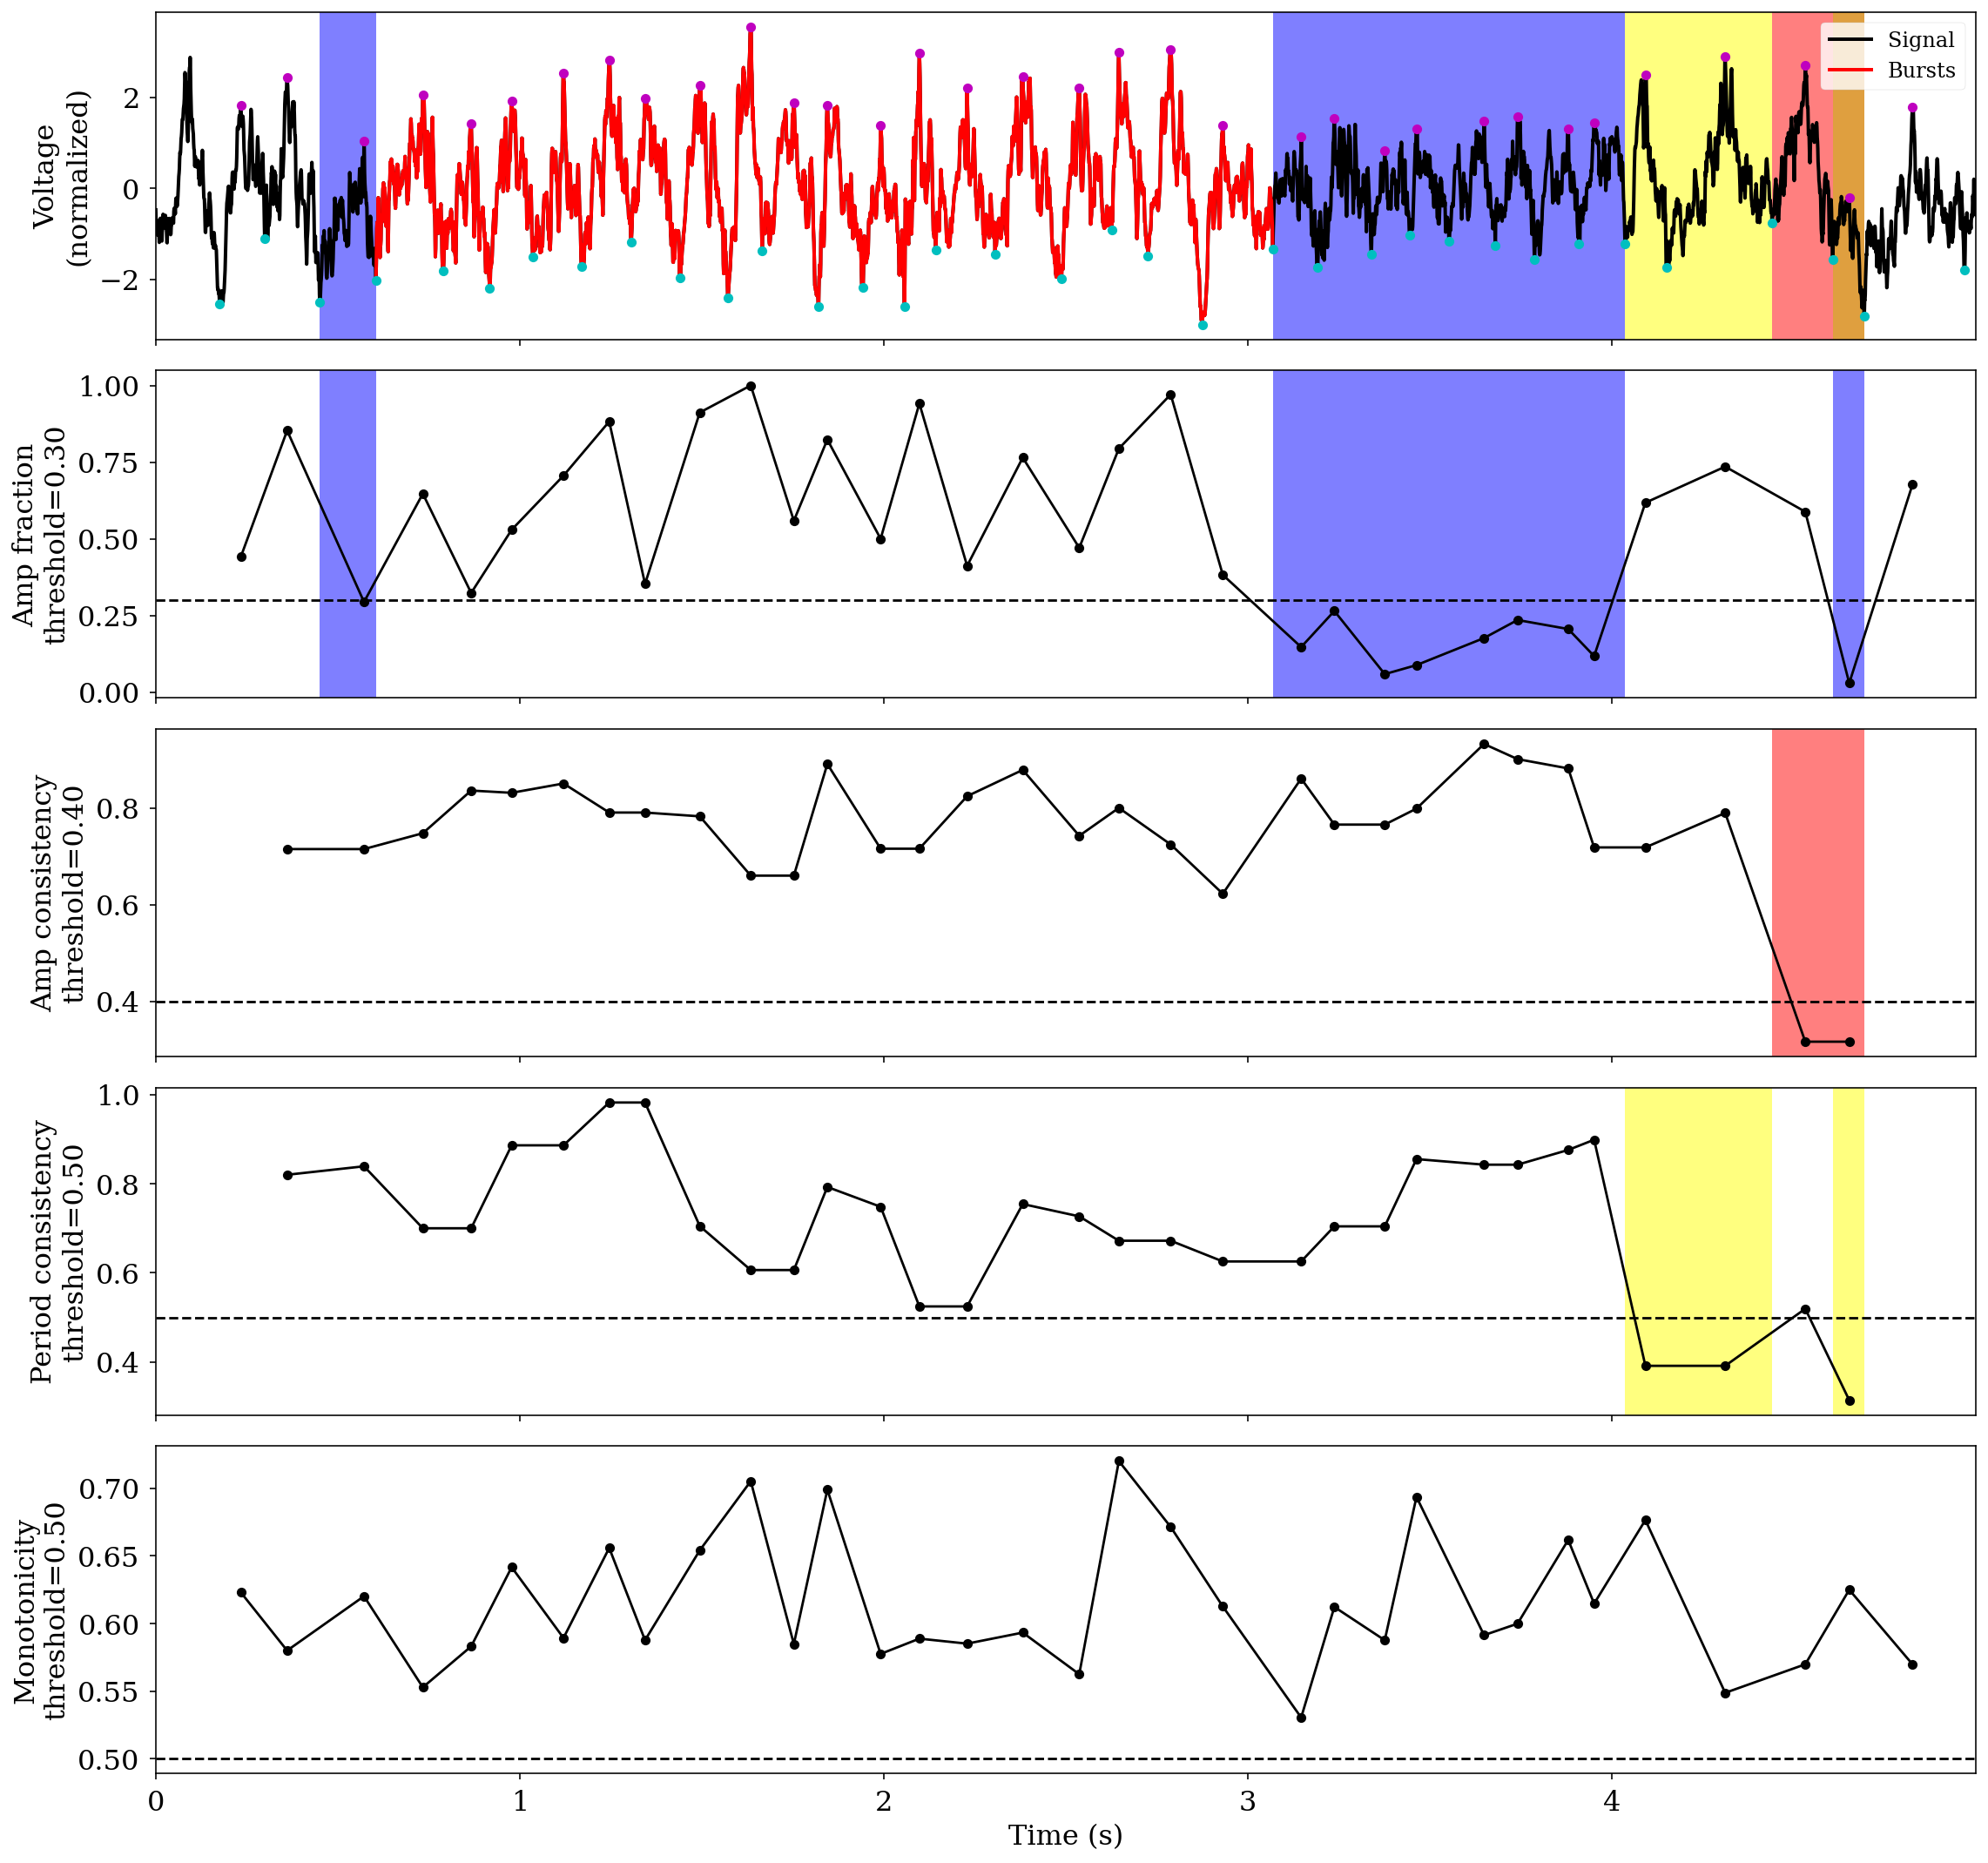

In [74]:
plot_burst_detect_summary(df_features, sigs, lfp.lfp.fs, threshold_kwargs, figsize=(16, 3))


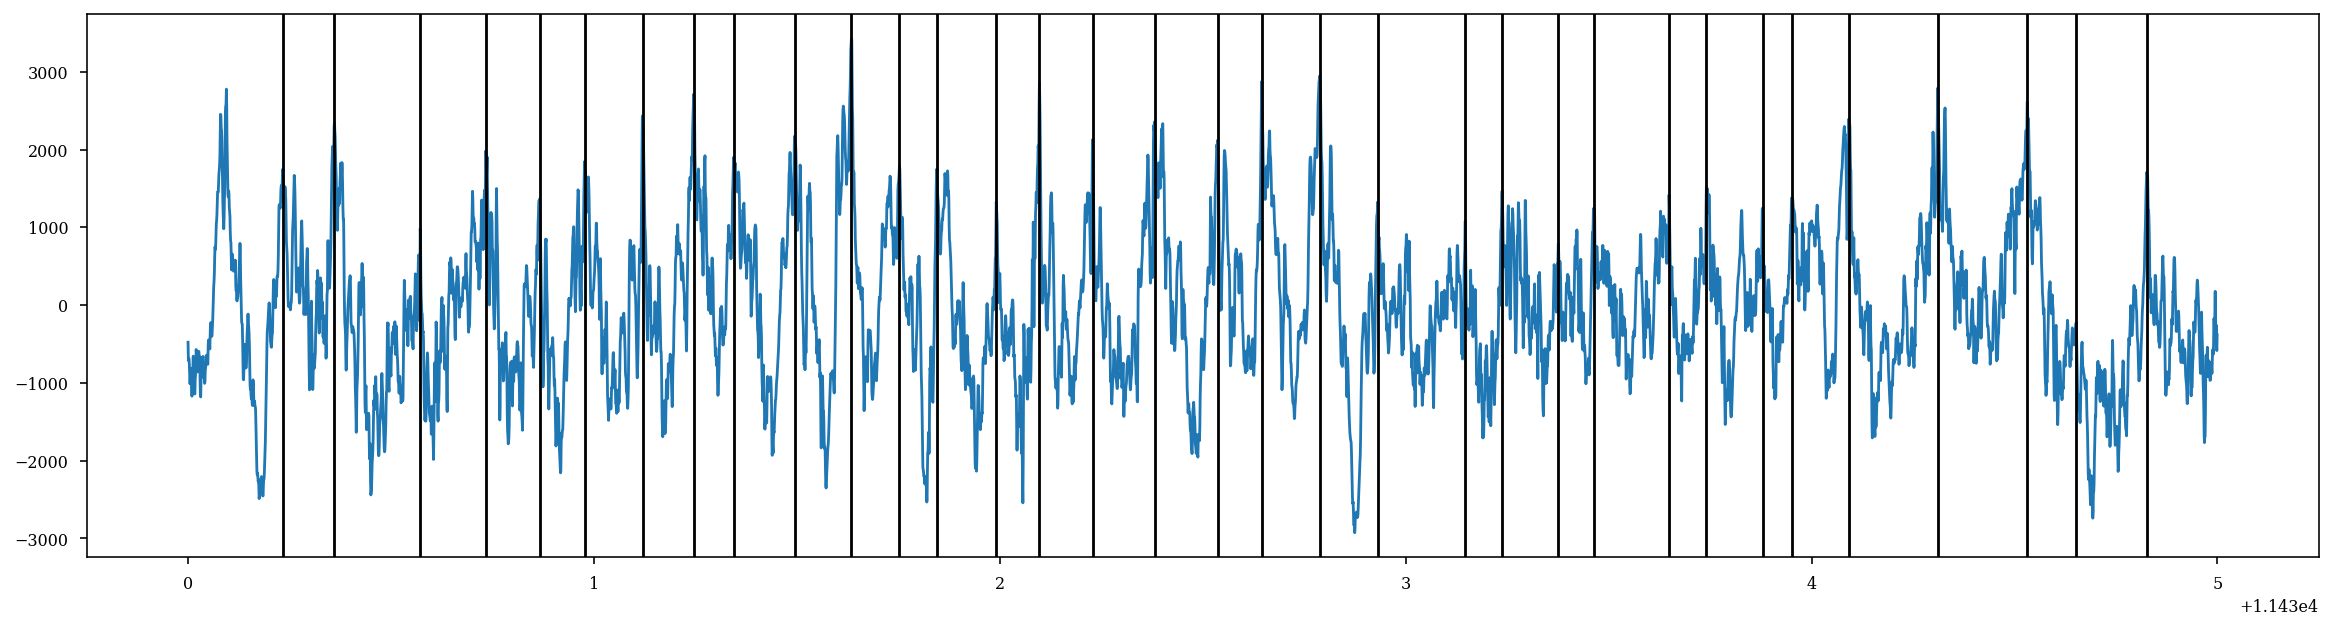

In [89]:
plt.figure(figsize=(20,5))
plt.plot(lfp.lfp[plotting_epoch.expand(2)].abscissa_vals, lfp.lfp[plotting_epoch.expand(2)].data[0])
# sample_peak	sample_last_zerox_decay	sample_zerox_decay	sample_zerox_rise	sample_last_trough	sample_next_trough
for temp_df in df_features.itertuples():
    plt.axvline(lfp.lfp[plotting_epoch.expand(2)].abscissa_vals[temp_df.sample_peak],color="k")
    # plt.axvline(lfp.lfp[plotting_epoch.expand(2)].abscissa_vals[temp_df.sample_last_zerox_decay])

    # plt.axvline(val)


In [55]:
df_features

,amp_fraction,amp_consistency,period_consistency,monotonicity,period,time_peak,time_trough,volt_peak,volt_trough,time_decay,...,time_rdsym,time_ptsym,band_amp,sample_peak,sample_last_zerox_decay,sample_zerox_decay,sample_zerox_rise,sample_last_trough,sample_next_trough,is_burst
0,1.000000,NaN,NaN,0.671296,186,96,93,2946.0,-1459.0,108,...,0.419355,0.507937,1539.143408,201,73,262,166,123,309,False
1,0.833333,0.622473,0.625514,0.612512,243,77,87,1328.0,-2926.0,172,...,0.292181,0.469512,746.503945,380,262,426,349,309,552,False
2,0.500000,0.860782,0.625514,0.530459,152,85,161,1079.0,-1320.0,55,...,0.638158,0.345528,670.879075,649,426,672,587,552,704,False
3,0.666667,0.765560,0.704301,0.612171,186,82,79,1468.0,-1708.0,127,...,0.317204,0.509317,736.460383,763,672,833,751,704,890,False
4,0.166667,0.765560,0.704301,0.587596,131,66,78,790.0,-1424.0,85,...,0.351145,0.458333,208.231894,936,833,977,911,890,1021,False
5,0.333333,NaN,NaN,0.693452,136,73,60,1244.0,-1011.0,112,...,0.176471,0.548872,336.093230,1045,977,1110,1037,1021,1157,False
